<a href="https://colab.research.google.com/github/saif9402/Dr-Wessam-Project/blob/main/Count_Vectorizer_Feature_Extarction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seifmohamedmamdouh","key":"8f063499136ccdd1a9cdf14264e78ce8"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Make sure you specify the correct dataset slug
!kaggle datasets download -d anupampaul005/fake-news-dataset

Dataset URL: https://www.kaggle.com/datasets/anupampaul005/fake-news-dataset
License(s): MIT


In [ ]:
!unzip -o fake-news-dataset.zip

Archive:  fake-news-dataset.zip
  inflating: dataset.csv             


In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import re, string, nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from xgboost import XGBClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

df = pd.read_csv('dataset.csv')
df['content'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
df['label'] = df['unreliable']
# Check result
print(df[['title', 'text', 'content', 'label']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                               title  \
0  WARNING: A Pivotal Moment For The Stock Market...   
1  Trump, top defense officials, discuss North Ko...   
2  British civil servants' union calls nationwide...   
3   A**hole Of The Day – Michele Bachmann: Muslim...   
4  ’Deport Fat People’ Posters Appear At CU Bould...   

                                                text  \
0  WARNING: A Pivotal Moment For The Stock Market...   
1  WASHINGTON  - U.S. President Donald Trump met ...   
2  LONDON  - British civil servants will vote nex...   
3  Michele Bachmann has been pretty quiet since l...   
4  Posters calling on Donald Trump to “Deport Fat...   

                                             content  label  
0  WARNING: A Pivotal Moment For The Stock Market...      1  
1  Trump, top defense officials, discuss North Ko...      0  
2  British civil servants' union calls nationwide...      0  
3   A**hole Of The Day – Michele Bachmann: Muslim...      1  
4  ’Deport Fat P

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    words = [w for w in text.split() if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)

In [ ]:
df['cleaned_content'] = df['content'].apply(preprocess)

# 🌟 STEP 9: Remove short documents (<5 words)
df = df[df['cleaned_content'].str.split().str.len() > 5]

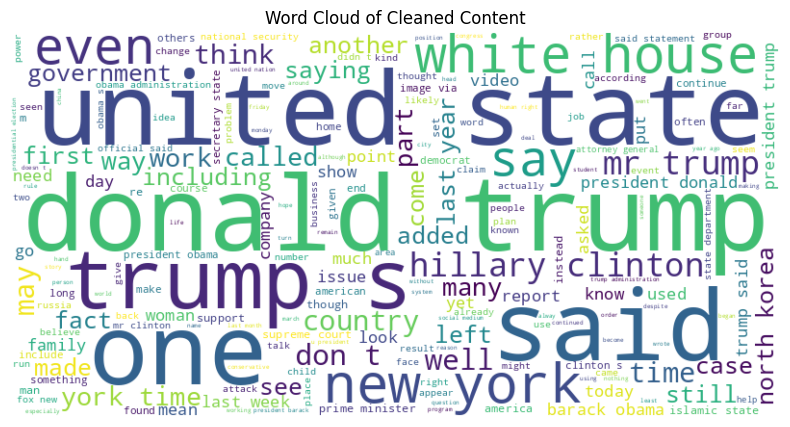

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(df['cleaned_content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Cleaned Content")
plt.show()


In [ ]:
# ---------------------- Data Splitting ----------------------

# Drop rows with missing text or label
df = df.dropna(subset=['cleaned_content', 'label'])

X = df['cleaned_content']
y = df['label']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


# ---------------------- Count Vectorizer ----------------------
vectorizer = CountVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
#Train models
log_model = LogisticRegression(max_iter=1000).fit(X_train_vec, y_train)
rf_model = RandomForestClassifier(n_estimators=300, max_depth=50, random_state=42).fit(X_train_vec, y_train)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss').fit(X_train_vec, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:14:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# ------------------ LSTM Model ------------------
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
max_len = 200

def prepare_lstm_data(X):
    return pad_sequences(tokenizer.texts_to_sequences(X), maxlen=max_len, padding='post')

X_train_pad = prepare_lstm_data(X_train)
X_val_pad = prepare_lstm_data(X_val)
X_test_pad = prepare_lstm_data(X_test)

lstm_model = Sequential([
    Embedding(5000, 64, input_length=max_len),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=10, batch_size=32, callbacks=[EarlyStopping(patience=3)])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 170s 135ms/step - accuracy: 0.7935 - loss: 0.4341 - val_accuracy: 0.9291 - val_loss: 0.2162
Epoch 2/10
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 199s 133ms/step - accuracy: 0.8280 - loss: 0.3893 - val_accuracy: 0.9569 - val_loss: 0.1229
Epoch 3/10
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 166s 135ms/step - accuracy: 0.9655 - loss: 0.1050 - val_accuracy: 0.9624 - val_loss: 0.1212
Epoch 4/10
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 199s 133ms/step - accuracy: 0.9824 - loss: 0.0609 - val_accuracy: 0.9679 - val_loss: 0.0939
Epoch 5/10
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 202s 134ms/step - accuracy: 0.9894 - loss: 0.0375 - val_accuracy: 0.9685 - val_loss: 0.1123
Epoch 6/10
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 200s 132ms/step - accuracy: 0.9927 - loss: 0.0262 - val_accuracy: 0.9654 - val_loss: 0.1257
Epoch 7/10
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 202s 132ms/step - accuracy: 0.9953 - loss: 0.0170 - val_accuracy: 0.9632 - val_loss: 0.1360


In [ ]:
def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


def evaluate_model(name, model, X_train, y_train, X_test, y_test, is_lstm=False):
    print(f"\n--- {name} ---")

    # Predict on training and testing sets
    if is_lstm:
        train_probs = model.predict(X_train).ravel()
        test_probs = model.predict(X_test).ravel()
        train_preds = (train_probs > 0.5).astype(int)
        test_preds = (test_probs > 0.5).astype(int)
    else:
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)
        train_probs = model.predict_proba(X_train)[:, 1]
        test_probs = model.predict_proba(X_test)[:, 1]

    # Training and Testing Accuracy
    print("Training Accuracy:", accuracy_score(y_train, train_preds))
    print("Testing Accuracy :", accuracy_score(y_test, test_preds))

    # Evaluation Metrics
    print("Accuracy :", accuracy_score(y_test, test_preds))
    print("Precision:", precision_score(y_test, test_preds, zero_division=0))
    print("Recall   :", recall_score(y_test, test_preds, zero_division=0))
    print("F1 Score :", f1_score(y_test, test_preds, zero_division=0))

    # AUC
    fpr, tpr, _ = roc_curve(y_test, test_probs)
    auc_score = auc(fpr, tpr)
    print("AUC      :", auc_score)

    # Plot Confusion Matrix
    plot_confusion(y_test, test_preds, title=f"{name} Confusion Matrix")

    # Plot ROC Curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")



--- Logistic Regression ---
Training Accuracy: 0.9983215929608626
Testing Accuracy : 0.9498779371376259
Accuracy : 0.9498779371376259
Precision: 0.9456345102673955
Recall   : 0.9568011958146487
F1 Score : 0.9511850806152017
AUC      : 0.9835059140934432


<Figure size 800x600 with 0 Axes>

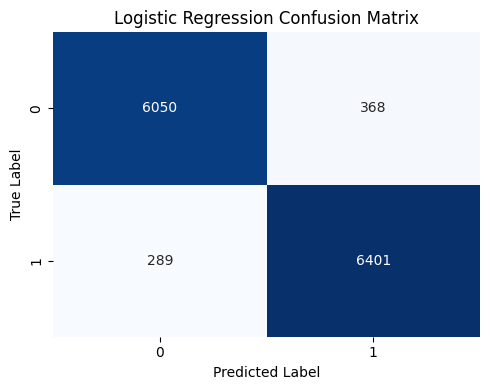


--- Random Forest ---
Training Accuracy: 0.9996439742644254
Testing Accuracy : 0.9595666768385719
Accuracy : 0.9595666768385719
Precision: 0.9716692189892803
Recall   : 0.9484304932735426
F1 Score : 0.959909228441755
AUC      : 0.9927606097574042


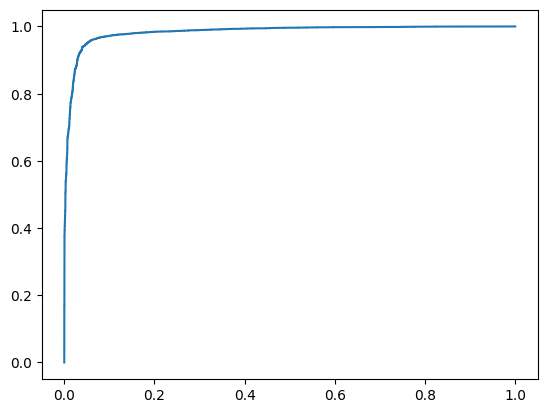

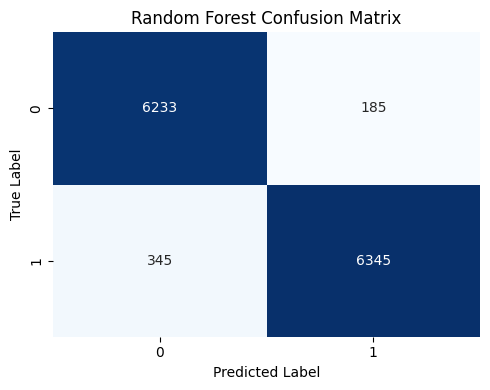


--- XGBoost ---
Training Accuracy: 0.9929557765175597
Testing Accuracy : 0.9685688129386634
Accuracy : 0.9685688129386634
Precision: 0.9690675433353257
Recall   : 0.9693572496263079
F1 Score : 0.9692123748318637
AUC      : 0.9945108022513288


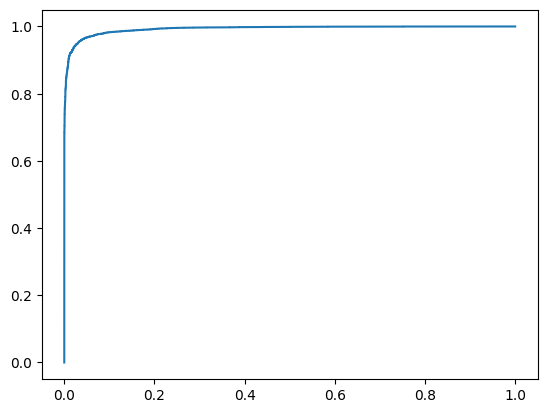

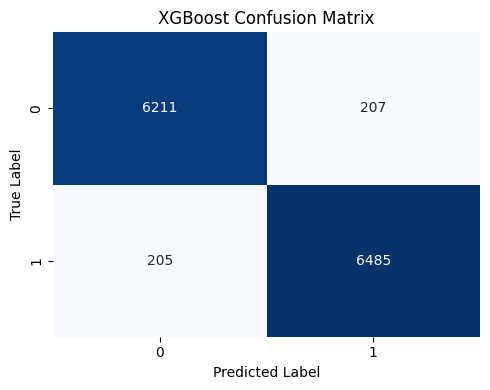


--- LSTM ---
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step
Training Accuracy: 0.996185438547415
Testing Accuracy : 0.9636100091547147
Accuracy : 0.9636100091547147
Precision: 0.9559665345662703
Recall   : 0.973542600896861
F1 Score : 0.9646745167740503
AUC      : 0.993338068241367


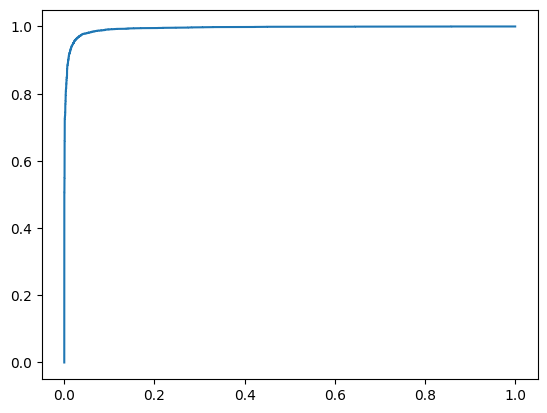

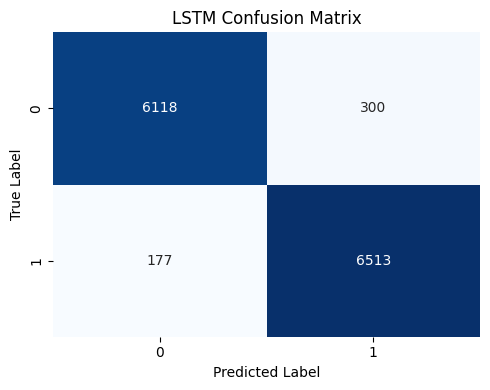

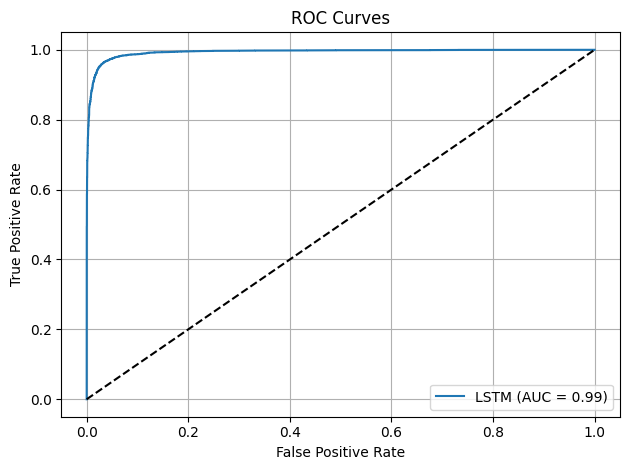

In [ ]:
plt.figure(figsize=(8, 6))

evaluate_model("Logistic Regression", log_model, X_train_vec, y_train, X_test_vec, y_test)
evaluate_model("Random Forest", rf_model, X_train_vec, y_train, X_test_vec, y_test)
evaluate_model("XGBoost", xgb_model, X_train_vec, y_train, X_test_vec, y_test)
evaluate_model("LSTM", lstm_model, X_train_pad, y_train, X_test_pad, y_test, is_lstm=True)

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
